# Лаб4 Мускатин Игорь КСм-21-1 

In [1]:
# pandas — программная библиотека на языке Python для обработки и анализа данных.
# подключаем для работы с данными и их обработки 
import pandas as pd

# seaborn — это библиотека для создания статистических графиков на Python
# она основывается на matplotlib и тесно взаимодействует со структурами данных pandas
# подключаем для перевода наших данных в графическое представление
import seaborn as sns 

sns.set() # установливаем стили для графиков - seaborn

import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans #библиотека для реализации кластеризации с помощью K-means 
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import warnings # инструмент контроля предупреждений
warnings.simplefilter('ignore') # отключаем несерьезные предупреждения

%matplotlib inline

# 1 Иерархическая кластеризация (Цветы Ириса)

Подключим исходные данные

In [2]:
data = pd.read_csv('IrisCategorical.csv', index_col='Id')
data

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
146,6.7,3.0,5.2,2.3,Iris-virginica
147,6.3,2.5,5.0,1.9,Iris-virginica
148,6.5,3.0,5.2,2.0,Iris-virginica


Выполним визуализацию данных по двум атрибутам. Сначала возьмем атрибут ирисов - Sepal, затем рассмотрим атрибут Petal.

<function matplotlib.pyplot.show(close=None, block=None)>

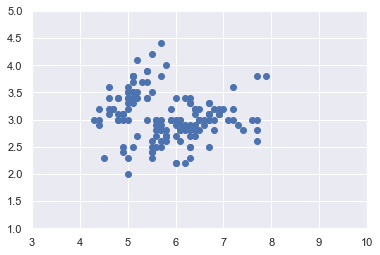

In [3]:
plt.scatter(data['SepalLengthCm'],data['SepalWidthCm'])  
plt.xlim(3,10)
plt.ylim(1,5) 
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

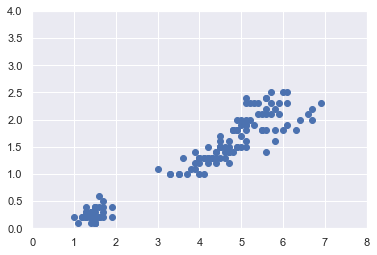

In [4]:
plt.scatter(data['PetalLengthCm'],data['PetalWidthCm'])  
plt.xlim(0,8)
plt.ylim(0,4) 
plt.show

Исходя из графической интерпретации исходных данных нет явно выделяющихся групп. 
Построим дендрограмму, для дальнейшего анализа.

## Sepal

In [5]:
new_data=data.drop(columns=['Species', 'PetalLengthCm', 'PetalWidthCm'], axis=1) # рассмотрим дендрограмму для атрибута Sepal

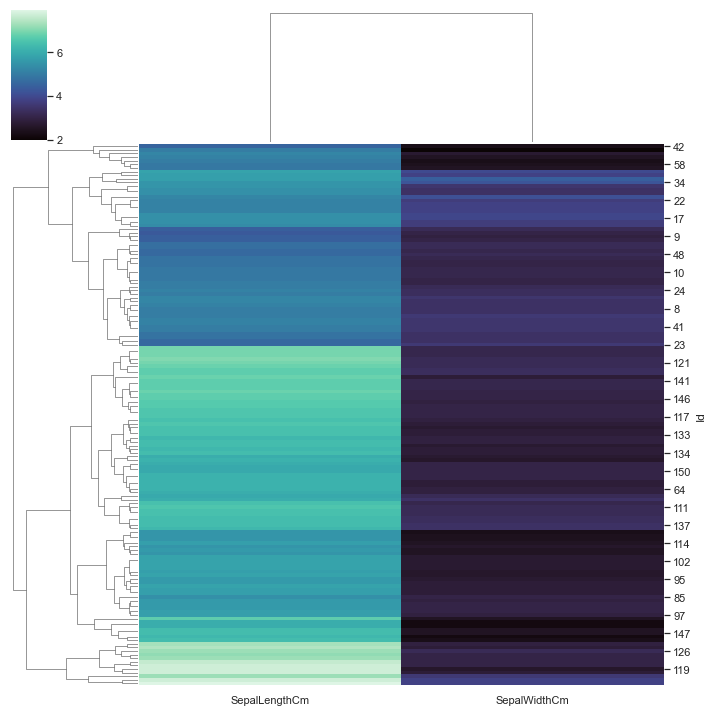

In [6]:
sns.clustermap(new_data, cmap='mako')

Далее выполним иерархическую кластеризацию используя метод single (MIN).

In [7]:
z = linkage(new_data,'single') # z-матрица содержащая информацию об объединении "точек" данных
print("z has %d rows"%(z.shape[0]))

z has 149 rows


Графически изобразим данные полученные в коде выше. Синяя линия в полученном графике показывает рекомендации для возможного среза.

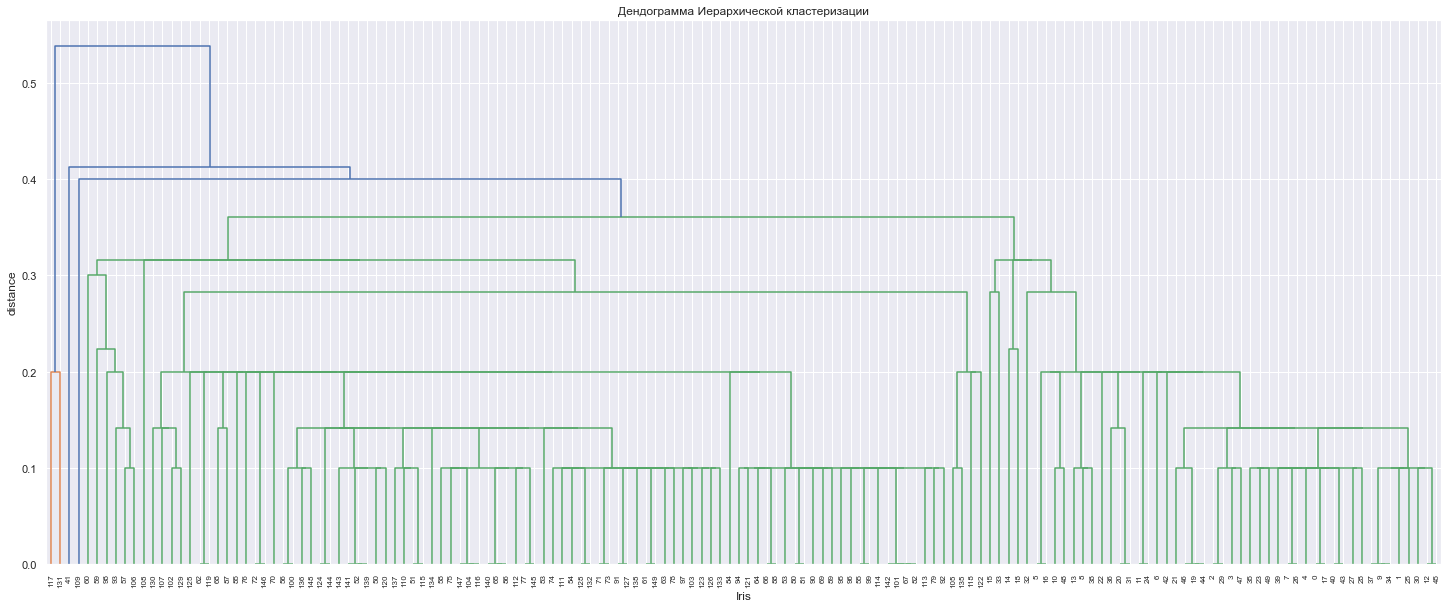

In [8]:
plt.figure(figsize=(25,10))
plt. title('Дендограмма Иерархической кластеризации')
plt.xlabel('Iris')
plt.ylabel('distance')
dendrogram(z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

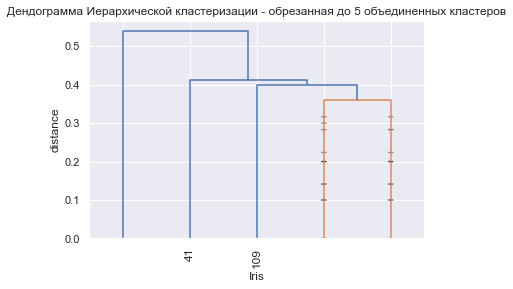

In [9]:
plt.title('Дендограмма Иерархической кластеризации - обрезанная до 5 объединенных кластеров')
 
plt.xlabel('Iris')
plt.ylabel('distance')
dendrogram(
    z,
    truncate_mode='lastp',
    p=5, # количество объединенных кластеров
    show_leaf_counts=False, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, 
)
plt.show()

Согласно синей линии мы можем разделить исходные данные на 2,3,4 кластера.

#### Knee/Eblow анализ 
Для решения задачи кластеризации также необходимо вычислим критерии WSS и BSS. Для удобства последующего использования создадим соответствующую функцию.

In [10]:
def KneeEblow(data, max_k):
    wss_values = []
    bss_values = []
    k_values=range(1, max_k)
    
    for k in k_values:
        clustering = fcluster(z, k, criterion='maxclust')
        centroids = [np.mean(data[clustering==c],axis=0) for c in range(1,k+1)]
        cdist(data, centroids, 'euclidean')
        D = cdist(data, centroids, 'euclidean')
        cIdx = np.argmin(D,axis=1)
        d = np.min(D,axis=1)
        avgWithinSS = sum(d)/data.shape[0]
        wss= sum(d**2) 
    
        tss = sum(pdist(data)**2)/data.shape[0]
        bss=tss-wss
        wss_values += [wss]
        bss_values += [bss]
    
    
    fig = plt.figure()
    
    font={'family': 'sans', 'size': 12}
    plt.rc('font', **font)
    
    plt.plot(k_values, wss_values, 'bo-', color='red', label='WSS')
    plt.plot(k_values, bss_values, 'bo-', color='blue', label='BSS')
    plt.grid(True)
    plt.xlabel('Количество кластеров')
    plt.ylabel('BSS & WSS')
    plt.xticks(k_values)
    plt.legend()
    plt.title('Knee/Eblow анализ');  

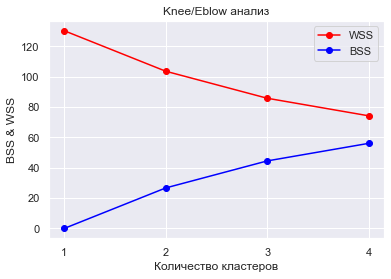

In [11]:
KneeEblow(new_data, 5)

Исходя из визуального анализа Knee/Eblow можем предположить что есть небольшие переломы в районе 2 и 3 кластера, но они не четко видны. Проведём дополнительную визуализацию, для более точного определения количества кластеров. 

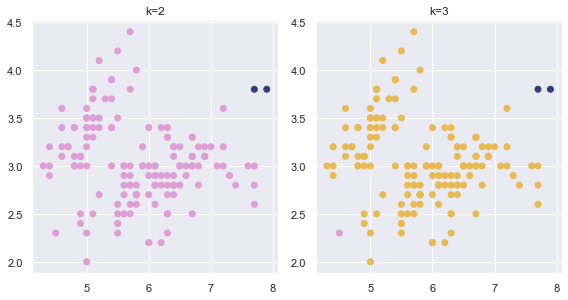

In [12]:
plt.figure(figsize=(12,12));
for k in range(2,4):
    yp=fcluster(z, k, criterion='maxclust')
    plt.subplot(330 +(k-1))
    plt.title('k='+str(k))
    plt.scatter(data['SepalLengthCm'],data['SepalWidthCm'], c=yp, cmap=plt.get_cmap('tab20b'))
plt.tight_layout()

Визуальноый анализ дает основание считать что в случае с анализом по Sepal методом Min получим 1 большой кластер, т.к. при отображении 2 и 3 кластеров, входящие в них элементы больше похожи на "помехи".

# Petal

In [13]:
new_data=data.drop(columns=['Species', 'SepalLengthCm', 'SepalWidthCm'], axis=1)

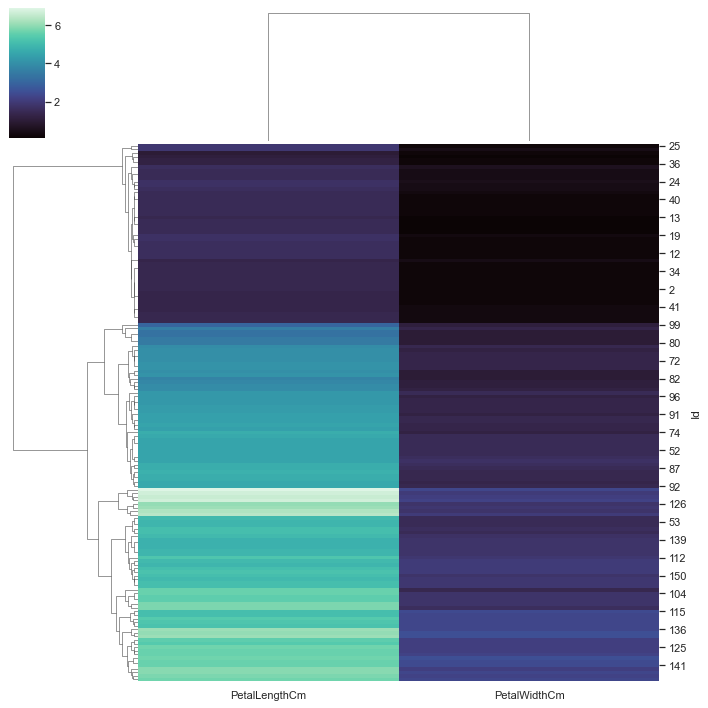

In [14]:
sns.clustermap(new_data, cmap='mako')

In [15]:
z = linkage(new_data,'single')
print("z has %d rows"%(z.shape[0]))

z has 149 rows


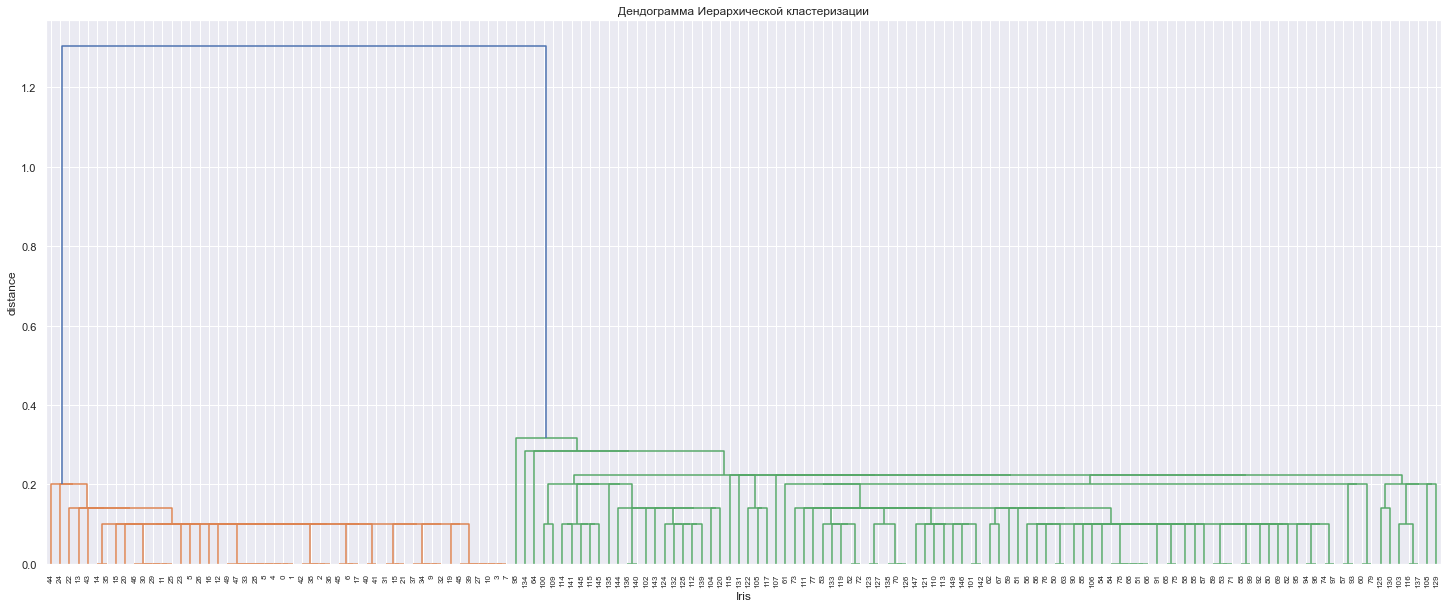

In [16]:
plt.figure(figsize=(25,10))
plt. title('Дендограмма Иерархической кластеризации')
plt.xlabel('Iris')
plt.ylabel('distance')
dendrogram(z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

Уже на этом графике вполне ярко видно разделение на 2 основных кластера, но в качестве проверки приблизим отображение до 5 кластеров.

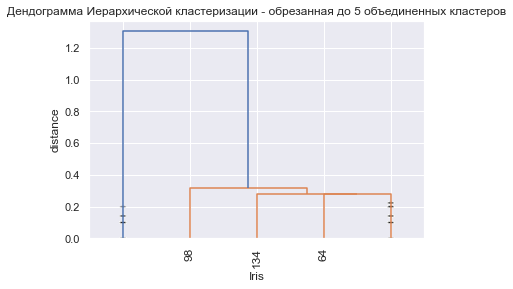

In [17]:
plt.title('Дендограмма Иерархической кластеризации - обрезанная до 5 объединенных кластеров') 
plt.xlabel('Iris')
plt.ylabel('distance')
dendrogram(
    z,
    truncate_mode='lastp',
    p=5,
    show_leaf_counts=False, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, 
)
plt.show()

Как и было написано выше, предлагается поделить на 2 кластера, выполним анализ Knee/Eblow.

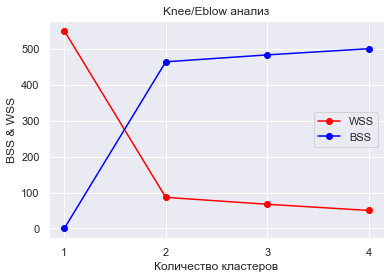

In [18]:
KneeEblow(new_data, 5)

В данном случае ярко выраженные переломы на 2 кластере. Проведем дополнительную визуализацию и увидим схожуя с предыдущим исследованием схожесть: два ярко выраженных кластера, а также при разделении на 3 кластера появляется 1 точка "шума".

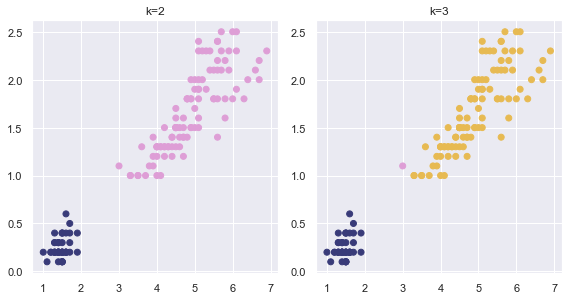

In [19]:
plt.figure(figsize=(12,12));
for k in range(2,4):
    yp=fcluster(z, k, criterion='maxclust')
    plt.subplot(330 +(k-1))
    plt.title('k='+str(k))
    plt.scatter(data['PetalLengthCm'],data['PetalWidthCm'], c=yp, cmap=plt.get_cmap('tab20b'))
plt.tight_layout()

Подводя итог анализа данных с помощью метода MIN, можно утверждать что данные обработанные данным способом говорят о том что в нашем наборе данных всего 2 кластера(вида ириса), что не соответствует действительности.
Для выполнения пункта задания: Выявить количество видов ириса в наборе, воспользуемся методом полной связи или методом MAX.

## Метод полной связи

In [20]:
z = linkage(new_data,'complete')
print("z has %d rows"%(z.shape[0]))

z has 149 rows


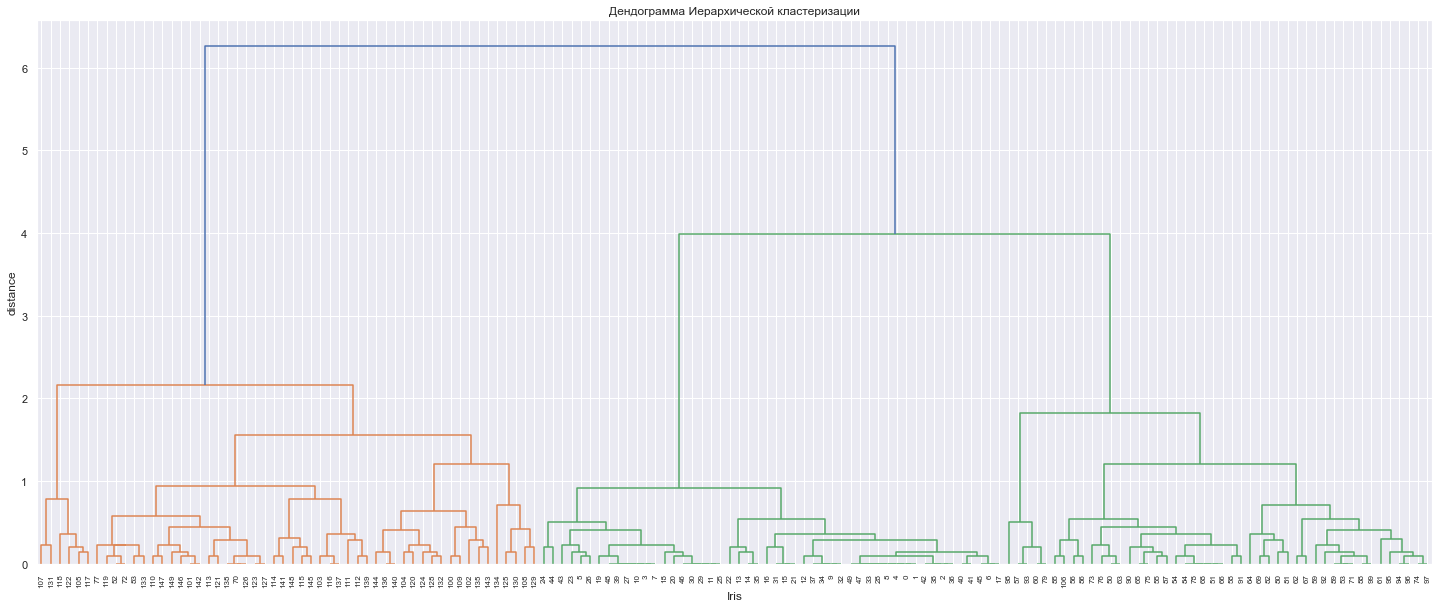

In [21]:
plt.figure(figsize=(25,10))
plt. title('Дендограмма Иерархической кластеризации')
plt.xlabel('Iris')
plt.ylabel('distance')
dendrogram(z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

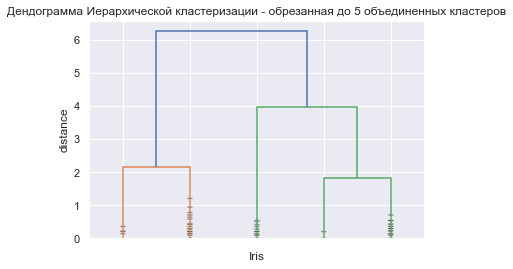

In [22]:
plt.title('Дендограмма Иерархической кластеризации - обрезанная до 5 объединенных кластеров') 
plt.xlabel('Iris')
plt.ylabel('distance')
dendrogram(
    z,
    truncate_mode='lastp',
    p=5,
    show_leaf_counts=False, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True, 
)
plt.show()

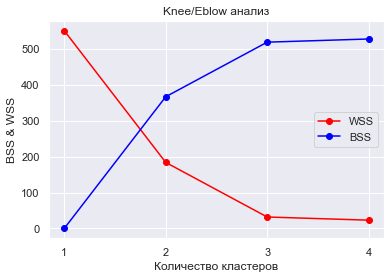

In [23]:
KneeEblow(new_data, 5)

Видим четкие переломы в 2 и 3 кластерах

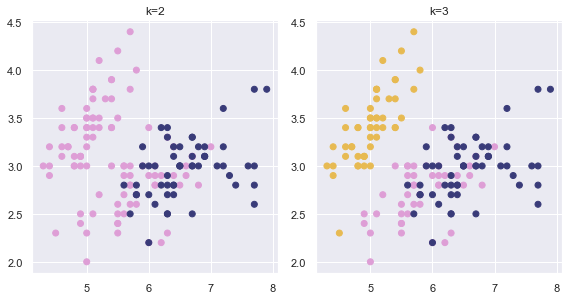

In [24]:
plt.figure(figsize=(12,12));
for k in range(2,4):
    yp=fcluster(z, k, criterion='maxclust')
    plt.subplot(330 +(k-1))
    plt.title('k='+str(k))
    plt.scatter(data['SepalLengthCm'],data['SepalWidthCm'], c=yp, cmap=plt.get_cmap('tab20b'))
plt.tight_layout()

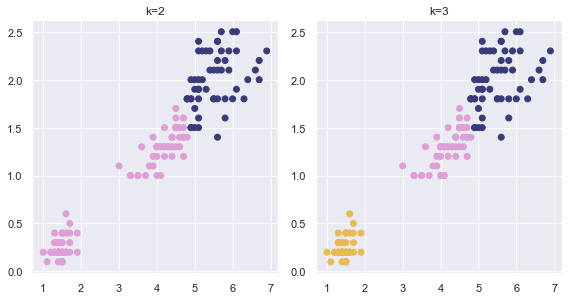

In [25]:
plt.figure(figsize=(12,12));
for k in range(2,4):
    yp=fcluster(z, k, criterion='maxclust')
    plt.subplot(330 +(k-1))
    plt.title('k='+str(k))
    plt.scatter(data['PetalLengthCm'],data['PetalWidthCm'], c=yp, cmap=plt.get_cmap('tab20b'))
plt.tight_layout()

Можем наблюдать на графиках выше, что метод Max справился с задачей определения количества видов Ирисов в нашем наборе более корректно и показал действительное количество - 3.